#GW170817
A significant astronomical event that marked the first observed merger of two neutron stars, detected through both gravitational waves and electromagnetic signals. This event was observed on August 17, 2017, by the LIGO and Virgo gravitational-wave observatories and subsequently by various telescopes worldwide, making it the first multi-messenger astronomy event.ollowing the gravitational wave detection, gamma-ray bursts were observed by the Fermi Gamma-ray Space Telescope and the INTEGRAL satellite. Subsequent observations across the electromagnetic spectrum (radio, optical, X-ray) were made by various telescopes.
Origin: The event occurred in the galaxy NGC 4993, located about 130 million light-years away.
Significance: GW170817 provided crucial insights into neutron star properties, the origin of heavy elements (like gold and platinum), and improved our understanding of the Hubble constant, which describes the rate of expansion of the universe.
For more detailed information, you can refer to the LIGO Scientific Collaboration's summary of GW170817.








In [ ]:
%%capture
!pip install gwpy
!pip install gwosc # provides an interface to querying the open data releases hosted on https://gwosc.org
!pip install h5py
!pip install pycbc
!pip install lalsuite
!pip install bilby
!pip install dynesty

In [ ]:
from gwpy.timeseries import TimeSeries, TimeSeriesDict, StateTimeSeries, StateVector
from gwpy.segments import Segment, DataQualityFlag
from gwpy.signal import filter_design
from gwpy.plot import Plot
from gwosc import datasets
from gwosc.api import fetch_event_json
from gwosc.locate import get_event_urls, get_urls
from gwosc.timeline import get_segments, timeline_url
from scipy import signal
from scipy.io import wavfile
from copy import deepcopy
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib import colormaps
import numpy as np
from numpy import random
from gwpy.table import EventTable, GravitySpyTable
from gwpy.time import to_gps


/usr/local/lib/python3.10/dist-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


In [ ]:
GPSGW = datasets.event_gps("GW170817")
print(f"GW170817-Center GPS Time:\n{GPSGW}")
dataGW = TimeSeries.fetch_open_data("L1",GPSGW-34,GPSGW+34)
segmentData = dataGW.q_gram(
    qrange=(4,150),
    search=Segment(GPSGW-0.25,GPSGW+0.25),
    mismatch=0.35
)
segmentData

GW170817-Center GPS Time:
1187008882.4


time,frequency,duration,bandwidth,energy
float64,float64,float64,float64,float64
1187008879.7436523,11.235294117647058,0.53125,0.4176880278369133,35.49808120727539
1187008880.2749023,11.235294117647058,0.53125,0.4176880278369133,183.91539001464844
1187008880.8061523,11.235294117647058,0.53125,0.4176880278369133,431.2776794433594
1187008881.3374023,11.235294117647058,0.53125,0.4176880278369133,576.4652099609375
1187008881.8686523,11.235294117647058,0.53125,0.4176880278369133,465.0181884765625
1187008882.3999023,11.235294117647058,0.53125,0.4176880278369133,217.65969848632812
1187008882.9311523,11.235294117647058,0.53125,0.4176880278369133,49.71782302856445
1187008879.7436523,11.397058823529411,0.53125,0.42370186069843996,67.57540893554688
1187008880.2749023,11.397058823529411,0.53125,0.42370186069843996,312.9818420410156


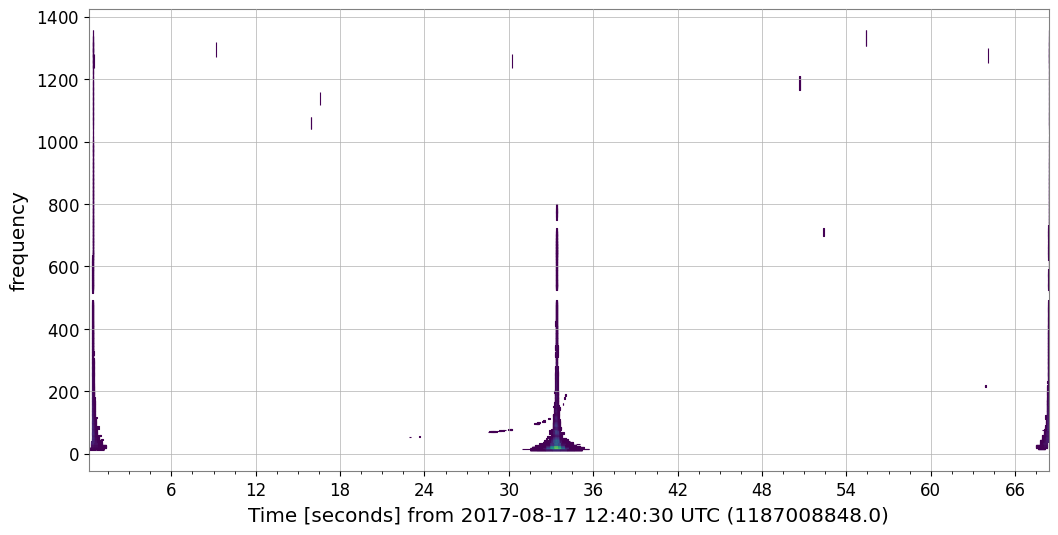

In [ ]:
plotTile = segmentData.tile(
    "time",
    "frequency",
    "duration",
    "bandwidth",
    color="energy"
)

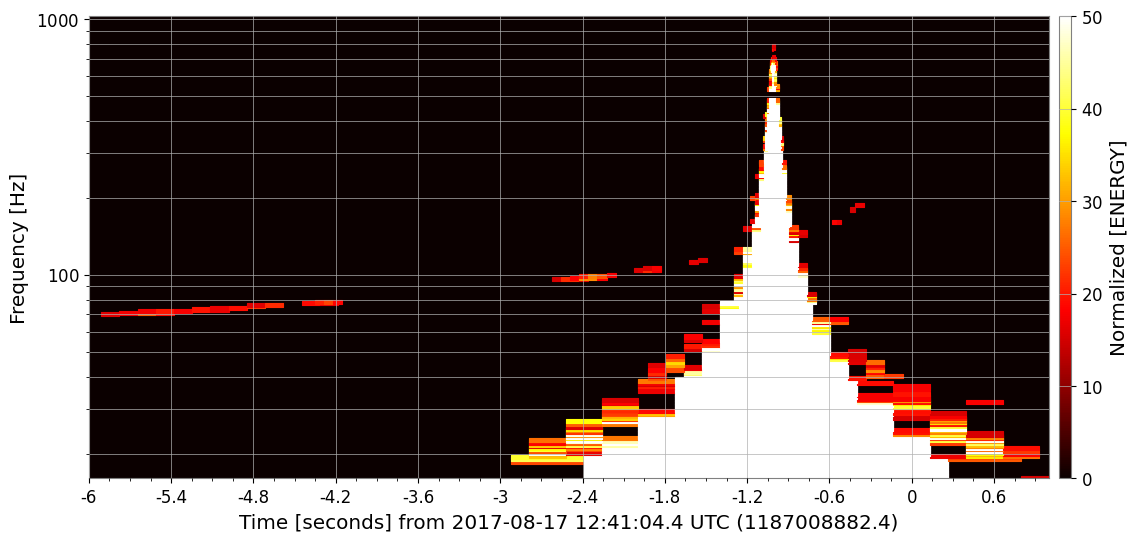

In [ ]:
plotTile = segmentData.tile(
    "time",
    "frequency",
    "duration",
    "bandwidth",
    color="energy"
)
ax = plotTile.gca()
ax.set_xscale("seconds")
ax.set_xlim(GPSGW-6,GPSGW+1)
ax.set_epoch(GPSGW)
ax.set_yscale("log")
ax.set_ylim(16,1024)
ax.set_ylabel("Frequency [Hz]")
ax.grid(True,axis="y",which="both")
cmap = colormaps["hot"]
ax.colorbar(cmap=cmap,label="Normalized [ENERGY]",clim=[0,50])
ax.set_facecolor(cmap(0))
plotTile.show()

In [ ]:
detector = "H1"
gps = 1187008882
gpsStart = 1186739814
gpsEnd = 1186743910
event = datasets.event_at_gps(gps)
gwData = TimeSeries.fetch_open_data(detector,gpsStart,gpsEnd)

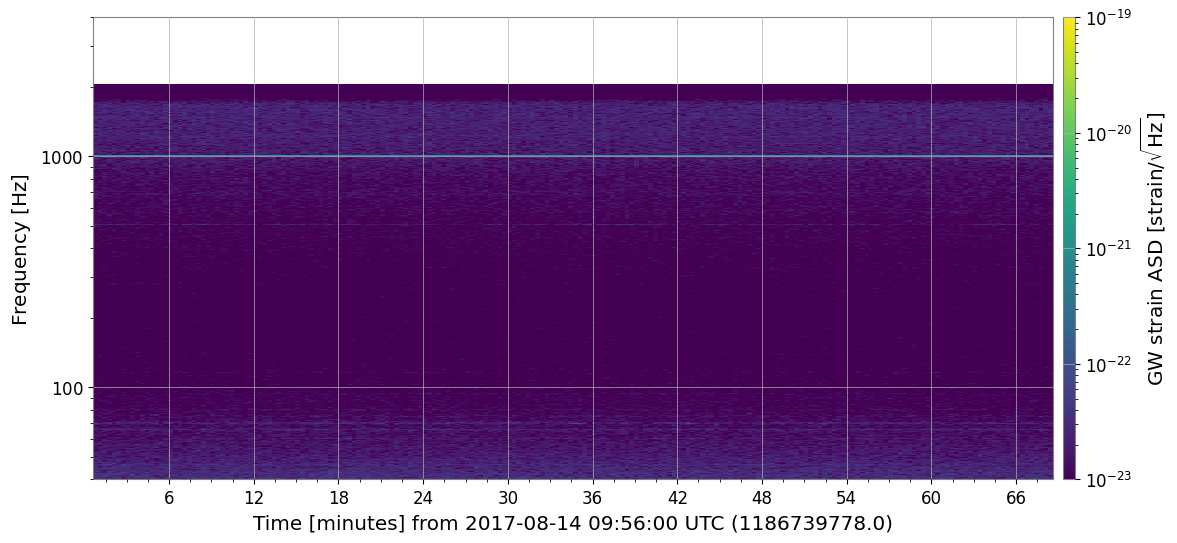

In [ ]:
spectrogram = gwData.spectrogram(20,fftlength=8,overlap=4)**(1/2.0)
plotSpectrogram = spectrogram.plot(norm="log",vmin=1e-23,vmax=1e-19)
ax = plotSpectrogram.gca()
ax.set_ylim(40,4000)
ax.set_yscale("log")
ax.colorbar(label="GW strain ASD [strain/$\sqrt{\mathrm{Hz}}$]")
plotSpectrogram.show()

In [ ]:
flow = 30 # lower corner frequency of pass band
fHigh = 500 # upper corner frequency of pass band
print(f"Data Sample Rate: {gwData.sample_rate}")

Data Sample Rate: 4096.0 Hz


In [ ]:
bandpassFilter = filter_design.bandpass(flow,fHigh,gwData.sample_rate)
notches = [filter_design.notch(line,gwData.sample_rate) for line in (60,120,180)]
zpk = filter_design.concatenate_zpks(bandpassFilter,*notches)

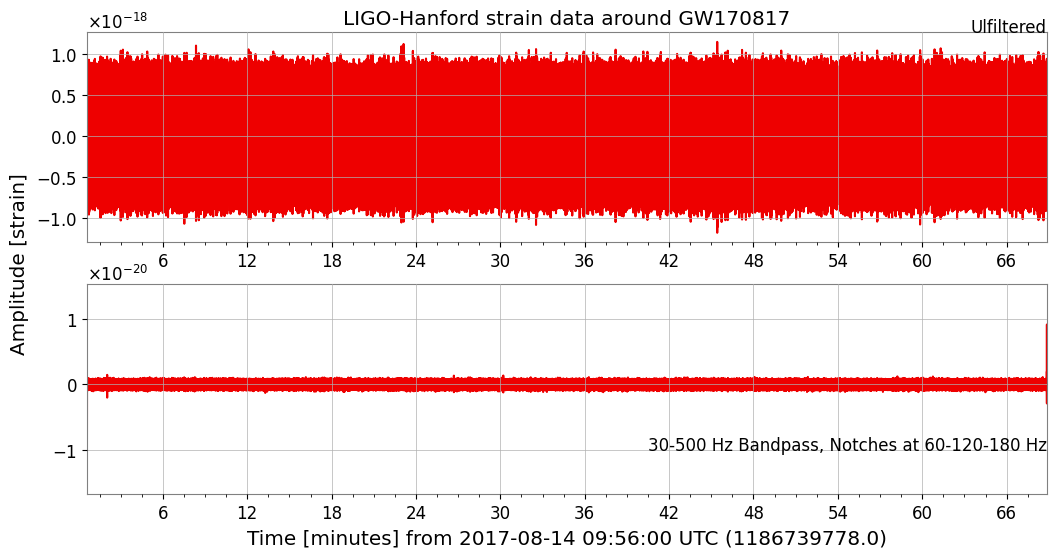

In [ ]:
gwFilter = gwData.filter(zpk,filtfilt=True)
plotGeneral = Plot(gwData,gwFilter,figsize=[12,6],separate=True,sharex=True,color="gwpy:ligo-hanford")
ax1,ax2 = plotGeneral.axes
ax1.set_title(f"LIGO-Hanford strain data around {event}")
ax1.set_ylabel("Amplitude [strain]",y=-0.1)
ax1.text(1.0,1.0,"Ulfiltered",transform=ax1.transAxes,ha="right")
ax2.set_ylabel("")
ax2.text(1.0,0.21,f"{flow}-{fHigh} Hz Bandpass, Notches at 60-120-180 Hz",transform=ax2.transAxes,ha="right")
plotGeneral.show()

In [ ]:
stateVector = StateVector.fetch_open_data(detector,gpsStart,gpsEnd)
print(stateVector)
flags = stateVector.to_dqflags()
print(flags)

StateVector([127, 127, 127, ..., 127, 127, 127]
            unit: dimensionless,
            t0: 1186739814.0 s,
            dt: 1.0 s,
            name: Data quality,
            channel: None,
            bits: Bits(0: Passes DATA test
                        1: Passes CBC_CAT1 test
                        2: Passes CBC_CAT2 test
                        3: Passes CBC_CAT3 test
                        4: Passes BURST_CAT1 test
                        5: Passes BURST_CAT2 test
                        6: Passes BURST_CAT3 test,
                        channel=None,
                        epoch=1186739814.0))
DataQualityDict([('Passes DATA test', <DataQualityFlag('Passes DATA test',
                 known=[[1186739814.0 ... 1186743910.0)]
                 active=[[1186739814.0 ... 1186743910.0)]
                 description=None)>), ('Passes CBC_CAT1 test', <DataQualityFlag('Passes CBC_CAT1 test',
                 known=[[1186739814.0 ... 1186743910.0)]
                 active=[[1186739

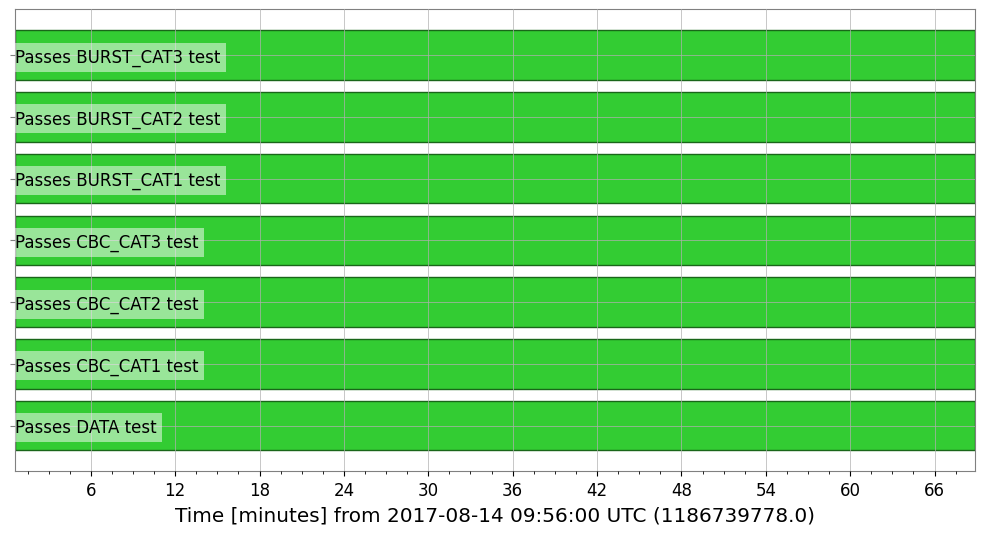

In [ ]:
passesBURSTCAT3Test = flags["Passes BURST_CAT3 test"]
passesBURSTCAT3Test
plot = stateVector.plot(insetlabels=True)
plot.show()

In [ ]:
gwtcSearch = EventTable.fetch_open_data("GWTC-3-confident")
gwtcSearch.colnames
gwtcSearch.info()

<EventTable masked=True length=35>
              name                dtype    unit            description           
-------------------------------- ------- ------- --------------------------------
                            name   str18                                         
                         jsonurl   str66                                  jsonurl
                  redshift_lower float64                           redshift_lower
         chirp_mass_source_upper float64 solMass          chirp_mass_source_upper
                chirp_mass_lower  object                         chirp_mass_lower
                chirp_mass_upper  object                         chirp_mass_upper
network_matched_filter_snr_lower float64         network_matched_filter_snr_lower
                   mass_1_source float64 solMass                    mass_1_source
                         chi_eff float64                                  chi_eff
         final_mass_source_upper float64 solMass          final

In [ ]:
filteredGWTC = gwtcSearch.filter("total_mass_source > 2")
filteredData = gwtcSearch.filter("network_matched_filter_snr > 15","luminosity_distance > 1000")

In [ ]:
startTime = to_gps("Jan 2015")
endTime = to_gps("Sept 2023")

In [ ]:
def FilterFunction(column,interval):
  "Returns `True` if ``interval[0] <= column < interval[1]``"
  query = (column >= interval[0]) & (column < interval[1])
  return query
filteredData  = gwtcSearch.filter(("GPS",FilterFunction,(startTime,endTime)))

In [ ]:
def HighMassRatio(table,threshold):
  query = (table["mass_1_source"]/table["mass_2_source"]) >= threshold
  return query

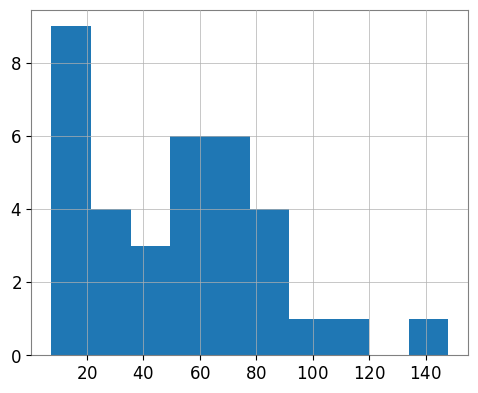

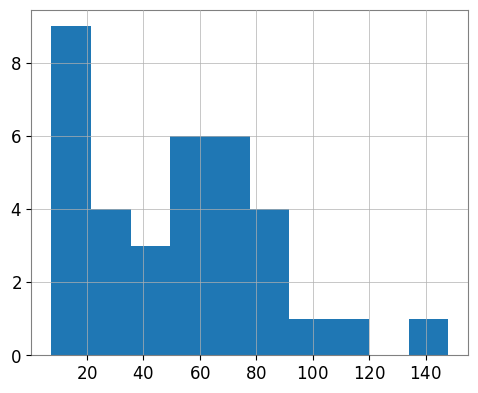

In [ ]:
filteredData = gwtcSearch.filter((("mass_1_source","mass_2_source"),HighMassRatio,3.0))
pandasFormat = gwtcSearch.to_pandas()
pandasFormat.to_csv("eventgwtc.csv")
gwtcSearch.hist(column="total_mass_source")

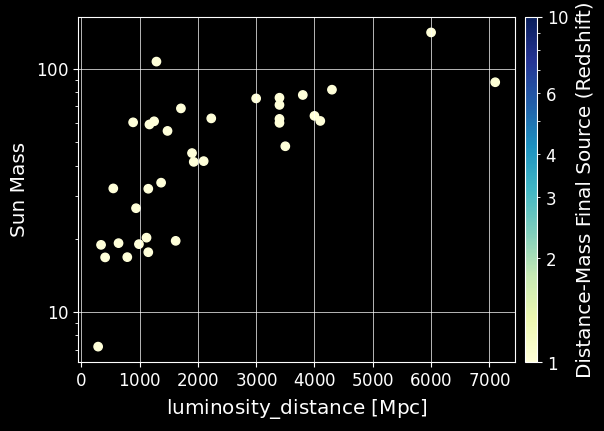

In [ ]:
plot = gwtcSearch.scatter("luminosity_distance","final_mass_source",color="redshift")
ax = plot.gca()
#ax.set_epoch(968654552)
ax.set_yscale("log")
ax.set_ylabel("Sun Mass")
ax.colorbar(
    clim=[1,10],
    cmap="YlGnBu",
    norm="log",
    label="Distance-Mass Final Source (Redshift)"
)

In [ ]:
segment = (int(gps)-10, int(gps)+5)
print(segment)


(1187008872, 1187008887)


Fetched 1 URLs from gwosc.org for [1187008872 .. 1187008887))
Reading data... [Done]
Fetched 1 URLs from gwosc.org for [1187008872 .. 1187008887))
Reading data... [Done]
Fetched 1 URLs from gwosc.org for [1187008872 .. 1187008887))
Reading data... [Done]


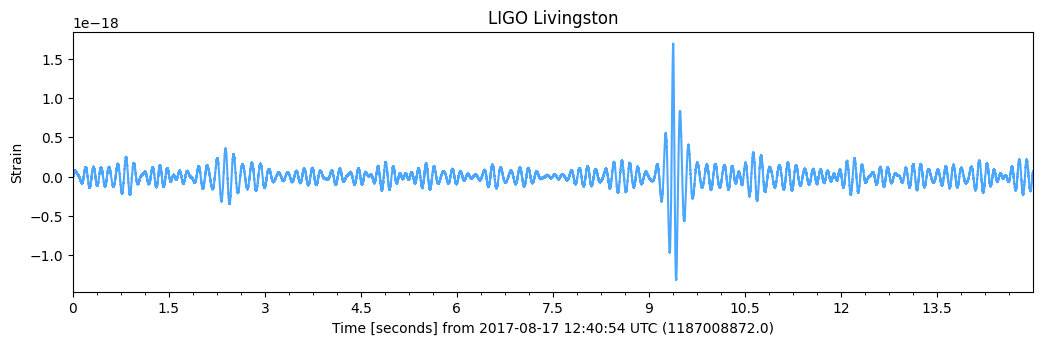

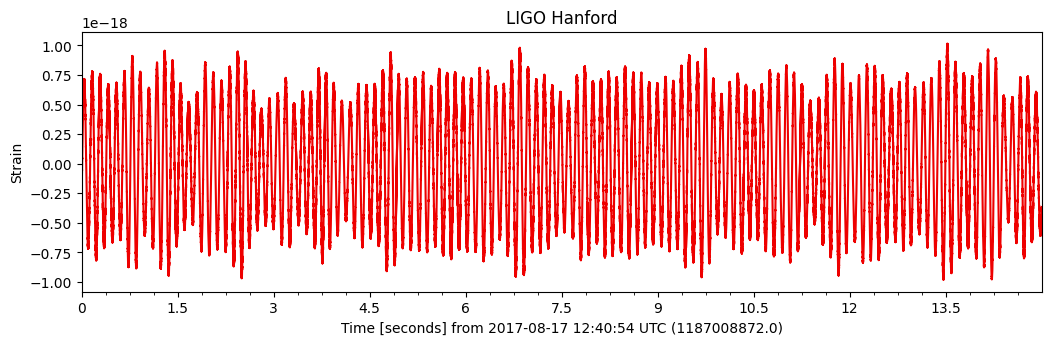

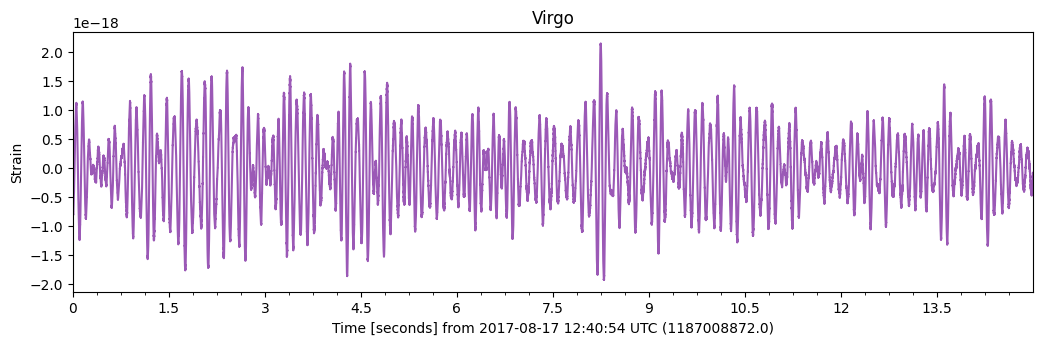

In [ ]:
plt.style.use("default")
ldata = TimeSeries.fetch_open_data('L1', *segment, verbose=True)
hdata = TimeSeries.fetch_open_data('H1', *segment, verbose=True)
vdata = TimeSeries.fetch_open_data('V1', *segment, verbose=True)
#Plotting time series
plotl = ldata.plot(title="LIGO Livingston", color='gwpy:ligo-livingston', ylabel='Strain')
ploth = hdata.plot(title="LIGO Hanford", color='gwpy:ligo-hanford', ylabel='Strain')
plotv = vdata.plot(title="Virgo", color='gwpy:virgo', ylabel='Strain')


In [ ]:
import bilby
from bilby.core.prior import Uniform, PowerLaw
from bilby.gw.conversion import convert_to_lal_binary_neutron_star_parameters, generate_all_bns_parameters

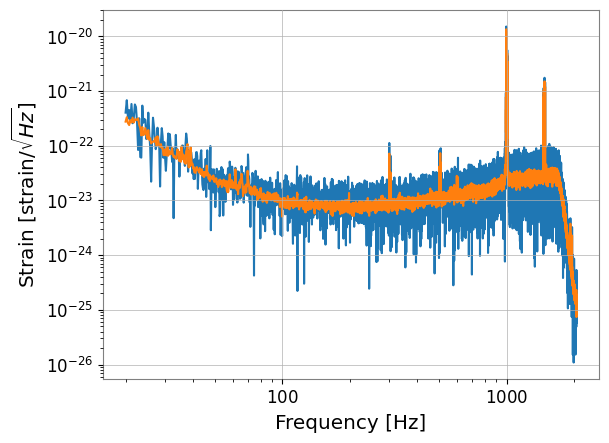

In [ ]:
H1 = bilby.gw.detector.get_empty_interferometer("H1")
V1 = bilby.gw.detector.get_empty_interferometer("V1")

# Defining times in relation to the trigger time (time_of_event), duration and post_trigger_duration
post_trigger_duration = 2
duration = 4
analysis_start = gps + post_trigger_duration - duration

H1_analysis_data = TimeSeries.fetch_open_data(
    "H1", analysis_start, analysis_start + duration, sample_rate=4096, cache=True)

V1_analysis_data = TimeSeries.fetch_open_data(
    "V1", analysis_start, analysis_start + duration, sample_rate=4096, cache=True)

H1.set_strain_data_from_gwpy_timeseries(H1_analysis_data)
V1.set_strain_data_from_gwpy_timeseries(V1_analysis_data)

psd_duration = duration * 32
psd_start_time = analysis_start - psd_duration

H1_psd_data = TimeSeries.fetch_open_data(
    "H1", psd_start_time, psd_start_time + psd_duration, sample_rate=4096, cache=True)

V1_psd_data = TimeSeries.fetch_open_data(
    "V1", psd_start_time, psd_start_time + psd_duration, sample_rate=4096, cache=True)
psd_alpha = 2 * H1.strain_data.roll_off / duration
H1_psd = H1_psd_data.psd(fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median")
V1_psd = V1_psd_data.psd(fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median")
H1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
    frequency_array=H1_psd.frequencies.value, psd_array=H1_psd.value)
V1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
    frequency_array=V1_psd.frequencies.value, psd_array=V1_psd.value)
fig, ax = plt.subplots()
idxs = H1.strain_data.frequency_mask  # This is a boolean mask of the frequencies which we'll use in the analysis
ax.loglog(H1.strain_data.frequency_array[idxs],
          np.abs(H1.strain_data.frequency_domain_strain[idxs]))
ax.loglog(H1.power_spectral_density.frequency_array[idxs],
          H1.power_spectral_density.asd_array[idxs])
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
plt.show()

In [ ]:
H1.maximum_frequency = 1024
V1.maximum_frequency = 1024

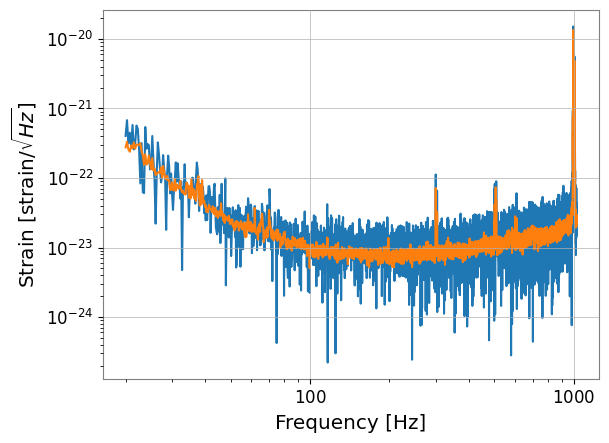

In [ ]:
fig, ax = plt.subplots()
idxs = H1.strain_data.frequency_mask
ax.loglog(H1.strain_data.frequency_array[idxs],
          np.abs(H1.strain_data.frequency_domain_strain[idxs]))
ax.loglog(H1.power_spectral_density.frequency_array[idxs],
          H1.power_spectral_density.asd_array[idxs])
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
plt.show()

In [ ]:
prior = bilby.core.prior.PriorDict()
prior['chirp_mass'] = Uniform(name='chirp_mass', minimum=1.1,maximum=1.2)
prior['mass_ratio'] = Uniform(name='mass_ratio', minimum=0.4, maximum=0.7)
prior['phase'] = Uniform(name="phase", minimum=0, maximum=2*np.pi)
prior['geocent_time'] = Uniform(name="geocent_time", minimum=gps-1, maximum=gps+1)
prior['a_1'] =  0.0
prior['a_2'] =  0.0
prior['tilt_1'] =  0.0
prior['tilt_2'] =  0.0
prior['phi_12'] =  0.0
prior['phi_jl'] =  0.0
prior['dec'] =  -23.3814
prior['ra'] =  13.1634
prior['theta_jn'] =  1.89694
prior['psi'] =  0.532268
prior['luminosity_distance'] = PowerLaw(alpha=2, name='luminosity_distance', minimum=40, maximum=200, unit='Mpc', latex_label='$d_L$')

In [ ]:
# Data created above put into list of interferometers
interferometers = [H1, V1]

# Specifying waveform approximant
waveform_arguments = dict(
    waveform_approximant='IMRPhenomPv2_NRTidal', reference_frequency=100., catch_waveform_errors=True)

# Creating a waveform_generator object.
waveform_generator = bilby.gw.WaveformGenerator(
    frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star,
    waveform_arguments=waveform_arguments,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters)

# Creating likelihood
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers, waveform_generator, priors=prior,
    time_marginalization=True, phase_marginalization=True, distance_marginalization=True)

20:19 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters
20:19 bilby INFO    : Distance marginalisation file .distance_marginalization_lookup.npz does not exist
20:19 bilby INFO    : Building lookup table for distance marginalisation.


  0%|          | 0/400 [00:00<?, ?it/s]

In [ ]:
result = bilby.run_sampler(
    likelihood=likelihood,
    priors=prior,
    conversion_function=bilby.gw.conversion.generate_all_bns_parameters,
    sampler='dynesty',
    nlive=250,
    label='GW_analysis',
    outdir='output'
)


20:36 bilby INFO    : Running for label 'GW_analysis', output will be saved to 'output'
20:36 bilby INFO    : Using lal version 7.5.0
20:36 bilby INFO    : Using lal git version Branch: None;Tag: lalsuite-v7.22;Id: 5c23000593918e5e4ef2ff809eccc1722b5d0795;;Builder: Unknown User <>;Repository status: UNCLEAN: Modified working tree
20:36 bilby INFO    : Using lalsimulation version 5.4.0
20:36 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsuite-v7.22;Id: 5c23000593918e5e4ef2ff809eccc1722b5d0795;;Builder: Unknown User <>;Repository status: UNCLEAN: Modified working tree
20:36 bilby INFO    : Analysis priors:
20:36 bilby INFO    : chirp_mass=Uniform(minimum=1.1, maximum=1.2, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None)
20:36 bilby INFO    : mass_ratio=Uniform(minimum=0.4, maximum=0.7, name='mass_ratio', latex_label='$q$', unit=None, boundary=None)
20:36 bilby INFO    : time_jitter=Uniform(minimum=-0.000244140625, maximum=0.000244140625, n

1446it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/dynesty/sampler.py:761: UserWarning: The sampling was stopped short due to maxiter/maxcall limit the delta(log(z)) criterion is not achieved; posterior may be poorly sampled
  warnings.warn('The sampling was stopped short due to'
20:38 bilby INFO    : Run interrupted by signal 2: checkpoint and exit on 130
20:38 bilby INFO    : Written checkpoint file output/GW_analysis_resume.pickle


Exception while calling loglikelihood function:
  params: [ 1.15566462e+00  6.34174162e-01 -1.70202891e-04]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/dynesty/dynesty.py", line 913, in __call__
    return self.func(np.asarray(x).copy(), *self.args, **self.kwargs)
  File "/usr/local/lib/python3.10/dist-packages/bilby/core/sampler/dynesty.py", line 53, in _log_likelihood_wrapper
    return _sampling_convenience_dump.likelihood.log_likelihood_ratio()
  File "/usr/local/lib/python3.10/dist-packages/bilby/gw/likelihood/base.py", line 408, in log_likelihood_ratio
    self.waveform_generator.frequency_domain_strain(self.parameters)
  File "/usr/local/lib/python3.10/dist-packages/bilby/gw/waveform_generator.py", line 131, in frequency_domain_strain
    return self._calculate_strain(model=self.frequency_domain_source_model,
  File "/usr/local/lib/python3.10/dist-packages/bilby/gw/waveform_generator.py", line 176, in _calculate_strain
    model_strain = self._strain_from_model(model_data_points, model)
  File "/usr/local/lib/python3.10/dist-packages/bilby/gw/wav

SystemExit: 130

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
# Convert the result to a dictionary
result_dict = {
    'parameter': result.posterior.keys(),
    'value': result.posterior.values()
}

# Create a DataFrame
df = pd.DataFrame(result_dict)

# Save the DataFrame to a CSV file
df.to_csv('posterior.csv', index=False)

In [ ]:
# Define a function to convert DataFrame to a bilby result object
def convert_df_to_bilby_result(df):
    posterior = df.set_index('parameter').T.to_dict('records')[0]
    result = bilby.core.result.Result(posterior=posterior)
    return result

# Read the CSV file into a DataFrame
df = pd.read_csv('posterior.csv')

# Convert the DataFrame back to a bilby result object
result = convert_df_to_bilby_result(df)

In [ ]:
result.posterior["chirp_mass"]

In [ ]:
Mc = result.posterior["chirp_mass"].values

In [ ]:
lower_bound = np.quantile(Mc, 0.05)
upper_bound = np.quantile(Mc, 0.95)
median = np.quantile(Mc, 0.5)
print("Mc = {} with a 90% C.I = {} -> {}".format(median, lower_bound, upper_bound))

In [ ]:
fig, ax = plt.subplots()
ax.hist(result.posterior["chirp_mass"], bins=20)
ax.axvspan(lower_bound, upper_bound, color='C1', alpha=0.4)
ax.axvline(median, color='C1')
ax.set_xlabel("chirp mass")
plt.show()


In [ ]:
result.plot_corner(parameters=["chirp_mass", "mass_ratio", "geocent_time", "phase"], prior=True)

In [ ]:
parameters = dict(mass_1=1.81, mass_2=1.11)
result.plot_corner(parameters)

In [ ]:
result.priors

In [ ]:
result.sampler_kwargs["nlive"]

In [ ]:
print("ln Bayes factor = {} +/- {}".format(
    result.log_bayes_factor, result.log_evidence_err))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import corner

# importing data for GW170817

label = 'GW170817'
! wget https://dcc.ligo.org/LIGO-P1800370/public/{label}_GWTC-1.hdf5

posterior_file = './'+label+'_GWTC-1.hdf5'
posterior = h5py.File(posterior_file, 'r')
print('This file contains the following datasets: ',posterior.keys())
samples=pd.DataFrame.from_records(np.array(posterior['IMRPhenomPv2NRT_highSpin_posterior']))
plt.hist(posterior['IMRPhenomPv2NRT_highSpin_posterior']['luminosity_distance_Mpc'], bins = 100, label='IMRPhenomPv2NRT_highSpin_posterior', alpha=0.8, density=True)
plt.hist(posterior['IMRPhenomPv2NRT_lowSpin_posterior']['luminosity_distance_Mpc'], bins = 100, label='IMRPhenomPv2NRT_lowSpin_posterior', alpha=0.8, density=True)
plt.xlabel(r'$D_L (Mpc)$')
plt.ylabel('Probability Density Function')
plt.title('Probability Density, Luminosity Distance GW170817')
plt.legend()
plt.show()

In [ ]:
plt.hist(posterior['IMRPhenomPv2NRT_highSpin_posterior']['costheta_jn'], bins = 100, label='IMRPhenomPv2NRT_highSpin_posterior', alpha=0.8, density=True)
plt.hist(posterior['IMRPhenomPv2NRT_lowSpin_posterior']['costheta_jn'], bins = 100, label='IMRPhenomPv2NRT_lowSpin_posterior', alpha=0.8, density=True)
plt.xlabel('cos(θ)')
plt.ylabel('Probability Density Function')
plt.title('Probability Density, cos(θ), GW170817')
plt.legend()
plt.show()

In [ ]:
import astropy.units as u
from astropy.cosmology import Planck15, z_at_value
z = np.array([z_at_value(Planck15.luminosity_distance, dist * u.Mpc) for dist in samples['luminosity_distance_Mpc']])
samples['m1_detector_frame_Msun']=samples['m1_detector_frame_Msun']/(1.0+z)
samples['m2_detector_frame_Msun']=samples['m2_detector_frame_Msun']/(1.0+z)
samples['redshift']=z
corner.corner(samples[['m1_detector_frame_Msun','m2_detector_frame_Msun']].values, labels=['Mass 1', 'Mass 2'], show_titles=True);

In [ ]:
corner.corner(samples[['spin1','spin2']].values,labels=['Spin object 1','Spin object 2'],show_titles=True);

In [ ]:
corner.corner(samples[['costilt1','costilt2']].values,labels=['cos tilt obj 1','cos tilt obj 2'],title='Title', show_titles=True);

In [ ]:
import bilby
# calculate the detector frame chirp mass
mchirp = ((samples['m1_detector_frame_Msun'] * samples['m2_detector_frame_Msun'])**(3./5))/\
         (samples['m1_detector_frame_Msun'] + samples['m2_detector_frame_Msun'])**(1./5)
# initialize a SampleSummary object to describe the chirp mass posterior samples
chirp_mass_samples_summary = bilby.core.utils.SamplesSummary(samples=mchirp, average='median')
print('The median chirp mass = {} Msun'.format(chirp_mass_samples_summary.median))
print('The 90% confidence interval for the chirp mass is {} - {} Msun'.format(chirp_mass_samples_summary.lower_absolute_credible_interval,
                                                                        chirp_mass_samples_summary.upper_absolute_credible_interval))